# BallNET demonstration
We have developed a network, which is designed to classify whether or not a ball is present in an image, and furthermore try to pinpoint the location of the ball in the image.

In [44]:
%reset
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pylab
import tensorflow as tf
import glob
import datetime
import os
import sys
import time

from skimage.io import imread
from skimage.transform import resize

from tensorflow.python.framework.ops import reset_default_graph
from tensorflow.contrib.layers import fully_connected, conv2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax
from tensorflow.python.ops.nn import dynamic_rnn

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [2]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.65)

## Get paths to data
Finds the path to the validation-demo data.

In [3]:
dataFolder = os.path.dirname(os.path.abspath("__file__"))
tfrecords_validation_regress_filename = 'demo_validation_regression.tfrecords'
tfrecords_validation_class_filename = 'demo_validation_classifier.tfrecords'

# Filepath to validation data for regression and classification
tfrecords_validation_regression = os.path.join(dataFolder,tfrecords_validation_regress_filename)
tfrecords_validation_classifier = os.path.join(dataFolder,tfrecords_validation_class_filename)

print("Regression data path: %s"% tfrecords_validation_regression)
print("Classification data path: %s"% tfrecords_validation_classifier)

Regression data path: /home/kristoffer/ballnet/demo_validation_regression.tfrecords
Classification data path: /home/kristoffer/ballnet/demo_validation_classifier.tfrecords


# Defining the data loader
The data consist of color images which are 128x128 pixels. The annotation consist of a flag which is ''1'' when a ball is present in the image, and ''0'' otherwise. The pixel coordinates of the location of the ball is also given. The data has been saved as a TFRecord.

In [4]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_CHANNELS = 3
IMAGE_SHAPE = [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS]
ANNOTATION_WIDTH = 3
NUM_OF_CLASSES = 2
NUM_OF_OUTPUTS = 2
VALIDATION_BATCH_SIZE = 5

CAPACITY = 4
NUM_THREADS = 8
MIN_AFTER_DEQUEUE = 2

NUM_EPOCHS = 1


def read_and_decode(filename_queue, batch_size):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'img_height': tf.FixedLenFeature([], tf.int64),
        'img_width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'annotation_width': tf.FixedLenFeature([], tf.int64),  
        'annotation_raw': tf.FixedLenFeature([], tf.string)
        })

    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['annotation_raw'], tf.uint8)
    
    img_height = tf.cast(features['img_height'], tf.int32)
    img_width = tf.cast(features['img_width'], tf.int32)
    annotation_width = tf.cast(features['annotation_width'], tf.int32)
    
    image_shape = tf.stack([img_height, img_width, IMAGE_CHANNELS])
    annotation_shape = tf.stack([1, annotation_width, 1])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)

    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_HEIGHT,
                                           target_width=IMAGE_WIDTH)
    
    resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
                                           target_height=1,
                                           target_width=ANNOTATION_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [resized_image, resized_annotation],
                                                 batch_size=batch_size,
                                                 capacity=CAPACITY,
                                                 num_threads=NUM_THREADS,
                                                 min_after_dequeue=MIN_AFTER_DEQUEUE)
    
    return images, annotations

# Display samples from dataset
The images and annotation for a batch can be seen below.

Validation images:


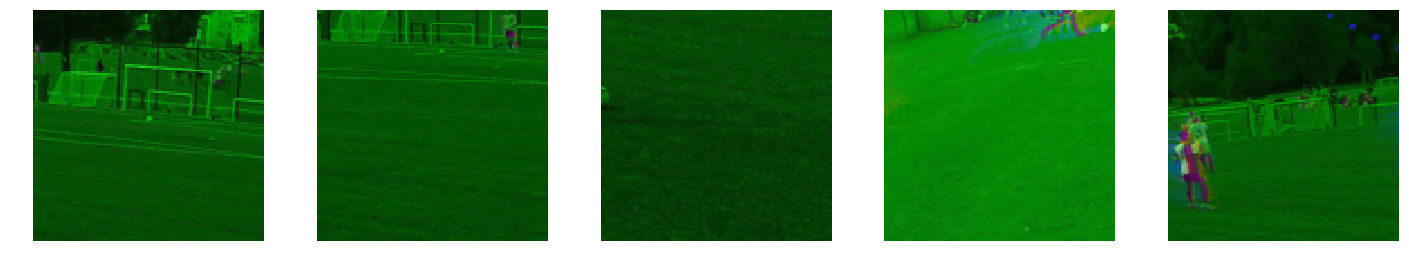

Classification of image (1=ball)
[1 1 0 1 0]

Regression annotation of image
[[ 64  60]
 [ 69  23]
 [  0   0]
 [122   9]
 [  0   0]]


In [5]:
tf.reset_default_graph()
# Array to contain loaded images
validation_image_appended = []
filename_validation_queue = tf.train.string_input_producer(
    [tfrecords_validation_classifier], num_epochs=NUM_EPOCHS)

# Define reader
validation_image, validation_annotation = read_and_decode(filename_validation_queue, VALIDATION_BATCH_SIZE)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))  as sess:
    
    sess.run(init_op)
    
    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
     
    NUM_OF_BATCHES = 1
    
    # Load batches of data
    for i in range(NUM_OF_BATCHES):
    
        validation_img, validation_anno = sess.run([validation_image, validation_annotation])
        
        # Append loaded images
        for j in range(validation_img.shape[0]):    
            validation_image_appended.append(validation_img[j,:,:,:])
        
        # Split annotation into regression and classification
        validation_anno = np.squeeze(validation_anno, axis=(1,3))
        validation_anno_class = validation_anno[:,0]
        validation_anno_reg = validation_anno[:,1:3]
        validation_anno_class = onehot(validation_anno_class,NUM_OF_CLASSES)
    

    # Stop threads
    coord.request_stop()
    coord.join(threads)
    
# Display validation images
print("Validation images:")
fig = plt.figure(figsize=(50, 50))
for idx in range(len(validation_image_appended)):
    plt.subplot(10, 10, idx + 1)
    image = np.squeeze(validation_image_appended[idx])
    plt.imshow(image)
    plt.axis('off')
plt.show()

print('Classification of image (1=ball)')
print(validation_anno[:,0])

print('\nRegression annotation of image')
print(validation_anno_reg)

# Define Model
The architecture of the network has been inspired by AlexNET. The foundation of the network consists of 5 convolutional layers and 3 pooling layers. On top, we have two different fully connected layers, one for classification and one for regression. The classifier uses a softmax function, and the regression uses linear activation to get the position estimates.

The trainable variables for the cnn, classification and regression part are saved, such that we can determine which parameters can be changed during the training of the network.

In [6]:
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_image_pl = tf.placeholder(tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name="x_image_pl")
t_pl_class = tf.placeholder(tf.float32, [None, NUM_OF_CLASSES], name="targets_pl_class")
t_pl_reg = tf.placeholder(tf.float32, [None, NUM_OF_OUTPUTS], name="targets_pl_reg")
preds_pl_class = tf.placeholder(tf.float32, [None, NUM_OF_CLASSES], name="pred_pl_class")
preds_pl_reg = tf.placeholder(tf.float32, [None, NUM_OF_OUTPUTS], name="pred_pl_reg")
is_training_pl = tf.placeholder(tf.bool, name="is_training_pl")

# ballNET architecture
with tf.variable_scope('Class_and_reg_model'):
    with tf.variable_scope('CNN'):
        # Convolution
        l_conv1 = conv2d(x_image_pl, num_outputs=96, kernel_size=[11, 11], stride=4, normalizer_fn=batch_norm, scope='l_conv1')
        l_pool1 = max_pool2d(l_conv1, kernel_size=[2, 2], stride=2, scope='l_pool1')
        l_conv2 = conv2d(l_pool1, num_outputs=256, kernel_size=[5, 5],stride=1, normalizer_fn=batch_norm, scope='l_conv2')
        l_pool2 = max_pool2d(l_conv2, kernel_size=[2, 2], stride = 2, scope='l_pool2')
        l_conv3 = conv2d(l_pool2, num_outputs=384, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv3')
        l_conv4 = conv2d(l_conv3, num_outputs=384, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv4')
        l_conv5 = conv2d(l_conv4, num_outputs=256, kernel_size=[3, 3],stride=1, normalizer_fn=batch_norm, scope='l_conv5')
        l_pool5 = max_pool2d(l_conv5, kernel_size=[2, 2], stride = 2, scope='l_pool5')
        l_flatten = flatten(l_pool5, scope="l_flatten")
    with tf.variable_scope('Classification'):
        # Classification
        l_2_class = fully_connected(l_flatten, num_outputs=32, activation_fn=relu, normalizer_fn=batch_norm, scope="l2_class")
        l_dropout_1_class = dropout(l_2_class, is_training=is_training_pl, scope="l2_dropout_class")
        y_class = fully_connected(l_dropout_1_class, NUM_OF_CLASSES, activation_fn=softmax, scope="y_class")
    with tf.variable_scope('Regression'):
        # Regression
        l_2_reg = fully_connected(l_flatten, num_outputs=32, activation_fn=relu, normalizer_fn=batch_norm, scope="l2_reg")
        l_dropout_1_reg = dropout(l_2_reg, is_training=is_training_pl, scope="l2_dropout_reg")
        y_reg = fully_connected(l_dropout_1_reg, NUM_OF_OUTPUTS, activation_fn=None, scope="y_reg")

# Define saver for trainable variables
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

# get trainable variables for regression
vars_cnn = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope ='Class_and_reg_model/CNN')
vars_class = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope ='Class_and_reg_model/Classification')
vars_cnn_class = vars_cnn + vars_class

# get trainable variables for regression
vars_reg = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope ='Class_and_reg_model/Regression')
vars_cnn_reg = vars_cnn + vars_reg

### Test forward pass

In [7]:
#Test the forward pass
_img_shape = tuple([8]+list(IMAGE_SHAPE))
_x_image = np.random.normal(0, 1, _img_shape).astype('float32') #dummy data

# test the forward pass
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    feed_dict = {x_image_pl: _x_image, is_training_pl: False}
    outputs = sess.run(fetches=[y_class, y_reg], feed_dict=feed_dict)
    
print("y_class:")
print(outputs[0])

print("y_reg:")
print(outputs[1])

y_class:
[[ 0.8844313   0.11556873]
 [ 0.65621483  0.3437852 ]
 [ 0.81244683  0.18755315]
 [ 0.93625689  0.06374313]
 [ 0.35742256  0.64257741]
 [ 0.91045064  0.08954942]
 [ 0.06714995  0.93285   ]
 [ 0.28789821  0.71210182]]
y_reg:
[[ 2.35164094 -1.27007818]
 [ 1.60550046  0.16690676]
 [ 0.54415667 -0.22650024]
 [-0.00513911 -0.11681736]
 [ 0.30930725  0.41347528]
 [-0.15833631 -1.44675446]
 [ 0.37139335  0.28542036]
 [ 0.92847168 -0.57365721]]


# Build and define cost functions
We have used the cross entropy cost function for the classification, and used a squared loss for the regression.

In [8]:
def loss_regularization(train_vars):
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = train_vars
    reg_term = sum([regularize(param) for param in params])
    loss = reg_term
    return loss

def loss_classification_validation(preds_class, train_vars):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(t_pl_class * tf.log(preds_class+1e-10), reduction_indices=[1])
    # averaging over samples
    loss = tf.reduce_mean(cross_entropy)
    loss = loss + loss_regularization(train_vars)
    
    # calculate accuracy
    argmax_y = tf.to_int32(tf.argmax(preds_class, axis=1))
    argmax_t = tf.to_int32(tf.argmax(t_pl_class, axis=1))
    correct = tf.to_float(tf.equal(argmax_y, argmax_t))
    accuracy = tf.reduce_mean(correct)
    
    # True positve etc.
    num_noball = tf.to_int32(tf.reduce_sum(t_pl_class[:,0]))
    num_ball = tf.to_int32(tf.reduce_sum(t_pl_class[:,1]))
    
    temp_equal = tf.equal(t_pl_class[:,0], 1)
    idx_noball = tf.where(temp_equal)
    temp_equal = tf.equal(t_pl_class[:,0], 0)
    idx_ball = tf.where(temp_equal)
    
    preds_given_noball = tf.gather_nd(argmax_y,idx_noball)
    preds_given_ball = tf.gather_nd(argmax_y,idx_ball)
    
    num_noball_correct = tf.reduce_sum(tf.to_int32(tf.equal(preds_given_noball, 0)))
    num_ball_correct = tf.reduce_sum(tf.to_int32(tf.equal(preds_given_ball, 1)))
    
    return loss, accuracy, num_ball_correct, num_noball_correct, num_ball, num_noball


def loss_reggression_validation(preds_reg, train_vars):
    l2_vec = tf.sqrt(tf.reduce_sum(tf.pow(t_pl_reg-preds_reg,2), reduction_indices=[1]))
    l2_mean = tf.reduce_mean(l2_vec)
    loss = tf.pow(l2_mean,2) + loss_regularization(train_vars)
    return loss, l2_vec, l2_mean

# Defining loss and accuracy for classification and regression
loss_reg, l2_vec, l2_mean = loss_reggression_validation(y_reg, vars_cnn_reg)
loss_class, accuracy_class, num_ball_correct, num_noball_correct, num_ball, num_noball = loss_classification_validation(y_class, vars_cnn_class)

## Validation benchmark Classification
The dataset we have used has more than 40000 validation images, however for this demo we are only using 300 images. The classification accuracy and a confusion matrix is shown below.

In [9]:
filename_validation_queue_benchmark = tf.train.string_input_producer([tfrecords_validation_classifier], num_epochs=1)
validation_image, validation_annotation = read_and_decode(filename_validation_queue_benchmark, VALIDATION_BATCH_SIZE)
load_name = "ballNET_loadfile"

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts,log_device_placement = True))  as sess:
    sess.run(init_op)
    # Restore variables from disk.
    saver.restore(sess, load_name)
    
    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    
    # Some validation stuff
    cur_acc = 0
    cur_num_ball_correct = 0
    cur_num_noball_correct = 0
    cur_num_ball = 0
    cur_num_noball = 0
    cur_loss = 0
    tot_num = 0   
    
    # Load validation data
    try:
        while(True):
            validation_img, validation_anno = sess.run([validation_image, validation_annotation])
            validation_anno = np.squeeze(validation_anno, axis=(1,3))
            validation_anno_class = validation_anno[:,0]
            validation_anno_class= onehot(validation_anno_class,NUM_OF_CLASSES)
            
            # fetches and feed_dict for validation
            fetches_valid = [accuracy_class, num_ball_correct, num_noball_correct, num_ball, num_noball, loss_class]
            feed_dict_valid = {
                x_image_pl: validation_img,
                t_pl_class: validation_anno_class,
                is_training_pl: False,
            }
            # run validation
            res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            
            cur_acc  += res_valid[0]*VALIDATION_BATCH_SIZE   # Validation accuracy 
            cur_num_ball_correct += res_valid[1]
            cur_num_noball_correct += res_valid[2]
            cur_num_ball += res_valid[3]
            cur_num_noball += res_valid[4]
            cur_loss += res_valid[5]
            tot_num += VALIDATION_BATCH_SIZE
            
    except tf.errors.OutOfRangeError:
        # Stop threads
        coord.request_stop()
        coord.join(threads)
    finally:
        # tensorboard and costs
        valid_acc_class = (cur_acc / float(tot_num)) * 100
        valid_loss_class = (cur_loss / float(tot_num))
        
        # Calculate confusion matrix
        conf_table_11 = cur_num_ball_correct/cur_num_ball * 100
        conf_table_12 = (cur_num_ball - cur_num_ball_correct)/cur_num_ball * 100
        conf_table_22 = cur_num_noball_correct/cur_num_noball * 100
        conf_table_21 = (cur_num_noball - cur_num_noball_correct)/cur_num_noball * 100
        
        print("Validation size: %d,\tClass Accuracy: %.1f\tClass loss: %.1f" % (tot_num, valid_acc_class, valid_loss_class))
        
        print("True\\Pred\t Ball\t No ball")
        print("Ball\t\t %.1f\t %.1f" % (conf_table_11, conf_table_12))
        print("No ball\t\t %.1f\t %.1f" % (conf_table_21, conf_table_22))

INFO:tensorflow:Restoring parameters from ballNET_loadfile
Validation size: 300,	Class Accuracy: 68.7	Class loss: 0.7
True\Pred	 Ball	 No ball
Ball		 68.0	 32.0
No ball		 30.7	 69.3


## Validation benchmark Regression
The validation data for the regression part consist only of images with a ball. The performance are evaluated based on the average distance between the predicted ball location, and the ''true'' location. The network is compared with the performance of guessing that the ball is in the center of the image.

In [10]:
filename_validation_queue_benchmark = tf.train.string_input_producer([tfrecords_validation_regression], num_epochs=1)
validation_image, validation_annotation = read_and_decode(filename_validation_queue_benchmark, VALIDATION_BATCH_SIZE)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts,log_device_placement = True))  as sess:
    sess.run(init_op)
    # Restore variables from disk.
    saver.restore(sess, load_name)

    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    
    # Some validation stuff
    cur_loss = 0
    cur_l2_mean = 0
    tot_num = 0
    loss_avg = 0
    # Load validation data
    try:
        while(True):
            validation_img, validation_anno = sess.run([validation_image, validation_annotation])
            validation_anno = np.squeeze(validation_anno, axis=(1,3))
            validation_anno_reg = validation_anno[:,1:3]
            
            loss_avg = loss_avg + np.sum(np.sqrt(np.sum(np.square(validation_anno_reg-np.array([64, 64])),axis=1)),axis=0)
            
            # fetches and feed_dict for validation
            fetches_valid = [loss_reg, l2_mean]
            feed_dict_valid = {
                x_image_pl: validation_img,
                t_pl_reg: validation_anno_reg,
                is_training_pl: False,
            }
            # run validation
            res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            
            cur_loss += res_valid[0]*VALIDATION_BATCH_SIZE   # Validation loss
            cur_l2_mean += res_valid[1]*VALIDATION_BATCH_SIZE   # Validation loss
            
            tot_num += VALIDATION_BATCH_SIZE
    except tf.errors.OutOfRangeError:
        # Stop threads
        coord.request_stop()
        coord.join(threads)
    finally:
        # tensorboard and costs
        valid_loss_reg = cur_loss / float(tot_num)
        valid_l2_mean =  cur_l2_mean / float(tot_num)
        loss_avg = loss_avg/ float(tot_num)

        print("Validation size: %d,\tReg Loss: %.2f"% (tot_num, valid_loss_reg))
        print("Avg pixel distance error (model): %.2f "% (valid_l2_mean))
        print("Avg pixel distance error (center): %.2f "% (loss_avg))

INFO:tensorflow:Restoring parameters from ballNET_loadfile
Validation size: 300,	Reg Loss: 1361.34
Avg pixel distance error (model): 35.66 
Avg pixel distance error (center): 49.65 


## Display Validation Image and Prediction
Here the prediction and ''true'' location of the ball is shown.

INFO:tensorflow:Restoring parameters from ballNET_loadfile
Regression predictions:


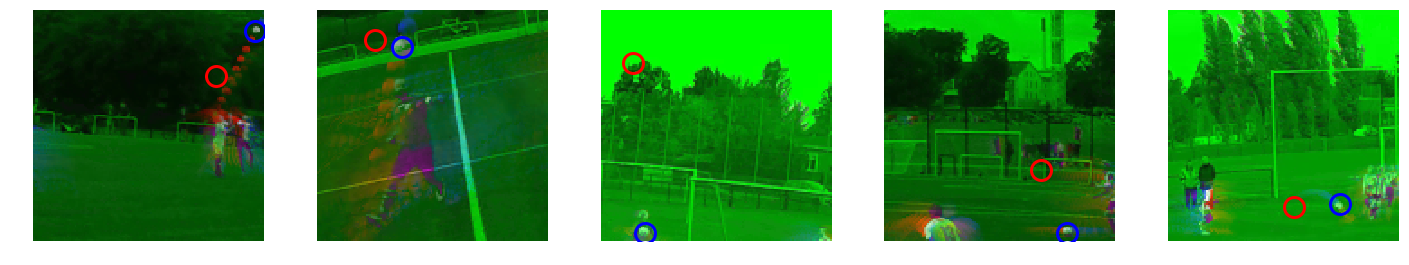

In [56]:
filename_validation_queue_benchmark = tf.train.string_input_producer([tfrecords_validation_regression], num_epochs=1)
validation_image, validation_annotation = read_and_decode(filename_validation_queue_benchmark, VALIDATION_BATCH_SIZE)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts,log_device_placement = True))  as sess:
    sess.run(init_op)
    # Restore variables from disk.
    saver.restore(sess, load_name)

    # Controlling of threads
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    validation_img, validation_anno = sess.run([validation_image, validation_annotation])
    validation_anno = np.squeeze(validation_anno, axis=(1,3))
    validation_anno_reg = validation_anno[:,1:3]
    validation_anno_class = validation_anno[:,0]
    validation_anno_class= onehot(validation_anno_class,NUM_OF_CLASSES)
            
            
    # fetches and feed_dict for validation
    fetches_valid = [y_reg, t_pl_reg, l2_vec, y_class, t_pl_class]
    feed_dict_valid = {
        x_image_pl: validation_img,
        t_pl_reg: validation_anno_reg,
        t_pl_class: validation_anno_class,
        is_training_pl: False,
    }
    # run validation
    res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)

    # Stop threads
    coord.request_stop()
    coord.join(threads)
    
ball_coor_pred = res_valid[0]
ball_coor_true = res_valid[1]
loss = res_valid[2]
ball_conf = res_valid[3]
ball_conf = ball_conf[:,1]

# Display training images
print("Regression predictions:")
fig = plt.figure(figsize=(50, 50))
for idx in range(len(validation_img)):
    plt.subplot(10, 10, idx + 1)
    image = np.squeeze(validation_img[idx])
    plt.imshow(image)
    pylab.plot( ball_coor_pred[idx,0],ball_coor_pred[idx,1], "o", markersize=20,markeredgewidth=3,markeredgecolor="r",markerfacecolor="None")
    pylab.plot( ball_coor_true[idx,0],ball_coor_true[idx,1], "o", markersize=20,markeredgewidth=3,markeredgecolor=(0,0,1),markerfacecolor="None")
    plt.axis('off')
plt.show()